In [1]:
import pandas as pd
import pyarrow.parquet as pq 
import numpy as np 

from sklearn.model_selection import train_test_split


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np
import tensorflow as tf 
import random

tf.random.set_seed(123)
np.random.seed(123)
random.seed(123)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
filepath  = r'/kaggle/input/fever-nli/fr_fever-00000-of-00001-b7ec330d6224f90b.parquet'

In [4]:
table = pq.ParquetDataset(filepath)
df = table.read().to_pandas()

In [5]:
df.head(2)

,premise_original,hypothesis_original,label,premise,hypothesis
0,Islam . Sizable Muslim communities are also fo...,Islam does not have any followers.,2,Des communautés musulmanes considérables se tr...,L’islam n’a pas d’adeptes.
1,Gemini is a 2002 Indian Tamil-language action ...,Gemini is a movie that came out in 2002.,0,Gemini est un film d'action indien écrit et ré...,Gemini est un film sorti en 2002.


In [6]:
df_trans = df.drop(columns = ['label'], axis = 1)

In [7]:
df_trans.head(2)

,premise_original,hypothesis_original,premise,hypothesis
0,Islam . Sizable Muslim communities are also fo...,Islam does not have any followers.,Des communautés musulmanes considérables se tr...,L’islam n’a pas d’adeptes.
1,Gemini is a 2002 Indian Tamil-language action ...,Gemini is a movie that came out in 2002.,Gemini est un film d'action indien écrit et ré...,Gemini est un film sorti en 2002.


In [8]:
english_premises = df_trans['premise_original'].values
english_premises = english_premises.tolist()
print(english_premises[0])
english_hypothesis = df_trans['hypothesis_original'].values
english_hypothesis = english_hypothesis.tolist()
print(english_hypothesis[0])

Islam . Sizable Muslim communities are also found in the Americas , Caucasus , China , Europe , Mainland Southeast Asia , Philippines and Russia .
Islam does not have any followers.


In [9]:
french_premises_ref = df_trans['premise'].values
french_premises_ref = french_premises_ref.tolist()
french_hypothesis_ref = df_trans['hypothesis'].values
french_hypothesis_ref = french_hypothesis_ref.tolist()

In [10]:
import re
def preprocess_text(text):
    # Step 1: Lowercasing
    text = text.lower()

    # Step 2: Removing special characters and punctuation
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

    # Step 3: Removing extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Preprocess the input sentences
preprocessed_english_hypothesis = [preprocess_text(sentence) for sentence in english_hypothesis]

In [11]:
preprocessed_english_hypothesis[:2]

['islam does not have any followers',
 'gemini is a movie that came out in 2002']

In [12]:
import tensorflow as tf
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer

# Load pre-trained model and tokenizer for translation
model_name = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

french_hypothesis = []

# English sentence to be translated
#english_sentence = "Hello, how are you?"

# Tokenize input sentence
for premise in preprocessed_english_hypothesis[:3]:
    # Tokenize input sentence
    inputs = tokenizer(premise, truncation=True, padding=True, return_tensors="tf")

    # Perform translation
    outputs = model.generate(inputs["input_ids"])
    french_ids = outputs[0].numpy()

    # Decode translated sentence
    french_sentence = tokenizer.decode(french_ids, skip_special_tokens=True)
    french_hypothesis.append(french_sentence)

# Print the translated sentences
print("English hypothesis:", preprocessed_english_hypothesis[2])
print("French hypothesis:", french_hypothesis[2])
print()

/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-en-fr.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


/opt/conda/lib/python3.10/site-packages/transformers/generation/tf_utils.py:854: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


English hypothesis: ted kaczynski is a serial arsonist
French hypothesis: Ted kaczynski est un pyromane en série



In [13]:
#Splitting hypothesis
english_train_hyp, english_test_hyp, french_train_hyp, french_test_hyp = train_test_split(preprocessed_english_hypothesis, french_hypothesis_ref, test_size = 0.2, random_state = 42)

In [14]:
#fine tuning hypothesis
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer, AdamWeightDecay
import tensorflow as tf

model_name = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize inputs and outputs
inputs = tokenizer(english_train_hyp[:20000], truncation=True, padding=True, return_tensors="tf")
outputs = tokenizer(french_train_hyp[:20000], truncation=True, padding=True, return_tensors="tf")

# Create a function that will transform our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# Create tf.data.Datasets
BATCH_SIZE = 16
tf_train_dataset = tf.data.Dataset.from_tensor_slices((inputs['input_ids'], inputs['attention_mask'], outputs['input_ids']))
tf_train_dataset = tf_train_dataset.map(map_func).shuffle(10000).batch(BATCH_SIZE)

tf_test_dataset = tf.data.Dataset.from_tensor_slices((inputs['input_ids'], inputs['attention_mask'], outputs['input_ids']))
tf_test_dataset = tf_test_dataset.map(map_func).batch(BATCH_SIZE)

optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)
model.compile(optimizer=optimizer)
model.fit(tf_train_dataset, validation_data=tf_test_dataset, epochs=3)


/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-en-fr.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Epoch 1/3
1250/1250 [==============================] - 463s 339ms/step - loss: 1.2572 - val_loss: 0.5313
Epoch 2/3
1250/1250 [==============================] - 418s 335ms/step - loss: 0.5548 - val_loss: 0.2932
Epoch 3/3
1250/1250 [==============================] - 381s 305ms/step - loss: 0.3620 - val_loss: 0.1873


In [15]:
save_directory = "/kaggle/working"  # Specify the directory to save the model

# Save the model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print("Model saved successfully.")

Model saved successfully.


In [16]:
import tensorflow as tf
#from transformers import TFBertModel, BertTokenizer
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

#saved_directory = "/kaggle/working"  # Specify the directory where the model was saved

# model = TFBertModel.from_pretrained(saved_directory)
# tokenizer = BertTokenizer.from_pretrained(saved_directory)

model_name = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(save_directory)
model = TFAutoModelForSeq2SeqLM.from_pretrained(save_directory)

french_predictions_hypothesis = []

# Function to predict French sentences
def predict_french_sentences(sentences):
    # Tokenize the input sentences
    tokenized_inputs = tokenizer(sentences, truncation=True, padding=True, return_tensors="tf")

    # Generate predictions
    predicted_ids = model.generate(tokenized_inputs.input_ids)
    predicted_sentences = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)

    return predicted_sentences

# Example usage
for i in range(2000):
    english_sentence = english_test_hyp[i]
    predicted_french_sentence = predict_french_sentences(english_sentence)
    french_predictions_hypothesis.append(predicted_french_sentence[0])
    if i % 50 == 0:
        print(f'Processed hypothesis sentences number: {i}')
    #print("English sentence:", english_sentence)
    #print("Predicted French sentence:", predicted_french_sentence[0])

# Print the predicted French sentence
# print("English sentence:", english_sentence)
# print("Predicted French sentence:", predicted_french_sentence)

All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at /kaggle/working.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


Processed hypothesis sentences number: 0
Processed hypothesis sentences number: 50
Processed hypothesis sentences number: 100
Processed hypothesis sentences number: 150
Processed hypothesis sentences number: 200
Processed hypothesis sentences number: 250
Processed hypothesis sentences number: 300
Processed hypothesis sentences number: 350
Processed hypothesis sentences number: 400
Processed hypothesis sentences number: 450
Processed hypothesis sentences number: 500
Processed hypothesis sentences number: 550
Processed hypothesis sentences number: 600
Processed hypothesis sentences number: 650
Processed hypothesis sentences number: 700
Processed hypothesis sentences number: 750
Processed hypothesis sentences number: 800
Processed hypothesis sentences number: 850
Processed hypothesis sentences number: 900
Processed hypothesis sentences number: 950
Processed hypothesis sentences number: 1000
Processed hypothesis sentences number: 1050
Processed hypothesis sentences number: 1100
Processed h

In [17]:
import pandas as pd

df = pd.DataFrame(french_predictions_hypothesis, columns = ['Predicted French Hypothesis'] )

df.to_csv('Predicted French hypo.csv', index = False)

In [18]:
from nltk.translate.bleu_score import corpus_bleu
reference_french_premises = french_test_hyp[:2000]

print(len(reference_french_premises))
print(len(french_predictions_hypothesis))
# print('Ref sen', reference_french_premises)
# print()
# print('pred sen', french_predictions)

tokenized_references = [[ref.split()] for ref in reference_french_premises]
tokenized_candidates = [pred.split() for pred in french_predictions_hypothesis]

# Print BLEU scores
bleu_scores = {}
bleu_scores['total'] = corpus_bleu(tokenized_references, tokenized_candidates)
bleu_scores['1-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(1.0, 0, 0, 0))
bleu_scores['1-2-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(0.5, 0.5, 0, 0))
bleu_scores['1-3-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(0.3, 0.3, 0.3, 0))
bleu_scores['1-4-grams'] = corpus_bleu(tokenized_references, tokenized_candidates, weights=(0.25, 0.25, 0.25, 0.25))
print("BLEU Scores:", bleu_scores)

2000
2000
BLEU Scores: {'total': 0.561179407844851, '1-grams': 0.7297186130151122, '1-2-grams': 0.6687143054709063, '1-3-grams': 0.6390508680228435, '1-4-grams': 0.561179407844851}


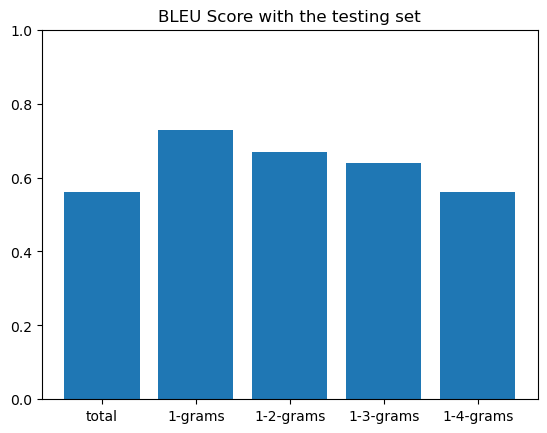

In [19]:
import matplotlib.pyplot as plt 
plt.bar(x = bleu_scores.keys(), height = bleu_scores.values())
plt.title("BLEU Score with the testing set")
plt.ylim((0,1))
plt.show()